# Wykorzystanie rekurencyjnych sieci neuronowych LSTM do przewidywania cen kryptowalut

Celem tego projektu jest wykorzystanie sieci neuronowych LSTM do przewidywania cen kryptowalut, na podstawie historycznych danych. Zaprezentowany zostanie kod, który przyjmuje listę danych w postaci [timestamp, cena], a następnie trenuje model, tworzy predykcje oraz wyświetla rezultaty.

**LSTM (Long Short-Term Memory)** to rodzaj sieci neuronowej rekurencyjnej (RNN), zaprojektowany specjalnie do uczenia się długoterminowych zależności. W przeciwieństwie do standardowych RNN, które mają problemy z zapamiętywaniem informacji przez długi czas, LSTM posiada specjalne mechanizmy, które pozwalają mu skutecznie przechowywać informacje przez dłuższe okresy.
#### Wzór:
![wzór LSTM](./Wzór.png)

$x_t \in \R^d$ - wektor wejściowy do jednostki LSTM

$f_t \in (0, 1)^h$ - wektor aktywacji bramy zapomnienia

$i_t \in (0, 1)^h$ - wektor aktywacji bramy wejścia/aktualizaji

$o_t \in (0, 1)^h$ - wektor aktywacji bramy wyjścia

$h_t \in (-1, 1)^h$ - wektor stanu ukrytego, znany również jako wektor wyjściowy jednostki LSTM

$\tilde{c}_t \in (-1, 1)^h$ - wektor aktywacji wejścia komórki

$c_t \in \R^h$ - wektor stanu komórki

$W \in \R^{h\times d}, U \in \R^{h\times h}, b \in \R^h$ - macierze wektorów aktywacji sygnału wejściowego komórki i parametry wektora odchylenia

$\sigma_g$ - sigmoidalna funkcja aktywacji

$\sigma_c, \sigma_h$ - hiperboliczne funkcje aktywacji

### Opis działania programu
### 
Na początku programu dokonuje się importu wykorzystywanych bibliotek oraz deklaracji konfigurowalnych zmiennych.

Konfigurowalne wartości:

- **Długość sekwencji (seq_length)** odnosi się do liczby przeszłych kroków czasowych w jednej sekwencji danych, które należy brać pod uwagę.

- **Epoka (epoch)** - jeden pełny cykl przejścia przez cały zbiór treningowy. Podczas jednej epoki, model przetwarza każdą próbkę z danych treningowych dokładnie jeden raz.

- **Rozmiar wsadu (batch_size)** - dane treningowe są często dzielone na mniejsze partie. zwane wsadami (batches). Rozmiar wsadu określa, ile próbek jest przetwarzanych przed aktualizacją wag. Liczba iteracji w jednej epoce jest równa liczbie wsadów.

- **Rozmiar danych (data_size)** - ilość danych wykorzystanych podczas wykonywania programu. W tym wypadku określa z jakiego okresu powinny zostać wykorzystane dane.

In [1]:
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

seq_length = 40
epochs = 200
batch_size = 60
data_size = 800

Następnie dokonuje się wczytania danych z pliku json, który zawiera informacje o cenach Bitcoina w określonym czasie. Dane te są umieszczane w strukturze danych pandas.

In [2]:
jsonData = json.load(open('dailyBTC.json', encoding="utf-8"))
    
data = pd.DataFrame(jsonData['prices'][:data_size])
data.rename(columns={0: 'DateTime', 1: 'Price'}, inplace=True)
data.index = pd.to_datetime(data['DateTime'], unit='ms')
data = data.drop(columns=['DateTime'])

Normalizacja jest jest ważnym krokiem w przetwarzaniu danych przed treningiem modelu, ponieważ przyspiesza i stabilizuje proces uczenia.
- **MinMaxScaler()**: Skaluje dane do zakresu [0, 1] (domyślnie).
- **fit_transform(data)**: Dopasowuje skalera do danych i jednocześnie przekształca dane.
#### Wzór:
$x' = \frac{x - min}{max - min}$

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

#### Podział danych na zbiory treningowe i testowe
- **train_size**: Liczba próbek w zbiorze treningowym (80% całego zestawu danych).
- **train_data**: Zbiór treningowy zawierający pierwsze 80% danych.
- **test_data**: Zbiór testowy zawierający pozostałe 20% danych.

In [4]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

### Tworzenie sekwencji

Sekwencje danych są tworzone do trenowania modelu LSTM.
- **create_sequences(data, seq_length)**: Funkcja do tworzenia sekwencji danych i etykiet.
  - **X**: Lista sekwencji wejściowych.
  - **y**: Lista wartości docelowych (etykiet).
- **seq_length**: Długość każdej sekwencji.
- **np.array()**: Konwersja list na tablice numpy.

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Model LSTM

Tworzenie i kompilacja modelu LSTM:
- **tf.keras.Sequential**: Inicjalizuje sekwencyjny model Keras.
- **tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1))**: Dodaje warstwę LSTM z 50 jednostkami i funkcją aktywacji ReLU. **input_shape** określa kształt wejściowy (długość sekwencji, liczba cech).
- **tf.keras.layers.Dense(1)**: Dodaje w pełni połączoną warstwę wyjściową z jedną jednostką.
- **compile(optimizer='adam', loss='mean_absolute_error')**: Kompiluje model z optymalizatorem Adam i funkcją straty MAE.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

#### Trening modelu na zbiorze treningowym:
- **fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)**: Trenuje model na danych treningowych.
  - **epochs**: Liczba epok treningowych.
  - **batch_size**: Wielkość partii danych.
  - **verbose**: Poziom szczegółowości wypisywanych informacji podczas treningu (1 = szczegółowe informacje).

In [7]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 6ms/step - loss: 0.5488
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 0.5032
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 0.4605
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 0.4193
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3715
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.3080
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1882
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1475
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0943
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1292
Epoch 11/200
4/4 [==============================] - 0s 6ms/step - loss: 0.1013
Epoch 12/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0980
Epoch 13/200
4/4 [==============================] - 0s 6ms/s

### Przewidywanie wyników modelu ###

- **predict(x, batch_size, verbose, steps, callbacks)**: Podaje wyniki wytrenowane modelu na podstawie danych wejściowych
    - **x**: Dane wejściowe.
    - **batch_size**: Liczba próbek na wsad.
    - **verbose**: Rodzaj tekstu wywoływanego do terminalu (0 - nic, 1 - progress bar, 2 - pojedyncza linijka).
    - **steps**: Ilość kroków (wsadów próbek).
    - **callbacks**: Lista wywołań zwrotnych, jakie ma wywoływać program.

In [8]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

1/1 [==============================] - 0s 10ms/step


Wykorzystanie biblioteki matplotlib do prezentacji otrzymanych wyników. Tworzone są kolejno wykresy, które przedstawiają:
- dane faktyczne na badanym zbiorze danych (czarna linia)
- predykcje na podstawie treningowych danych (niebieska linia)
- predykcje otrzymane z wykorzystaniem stworzonego modelu (czerwona linia)

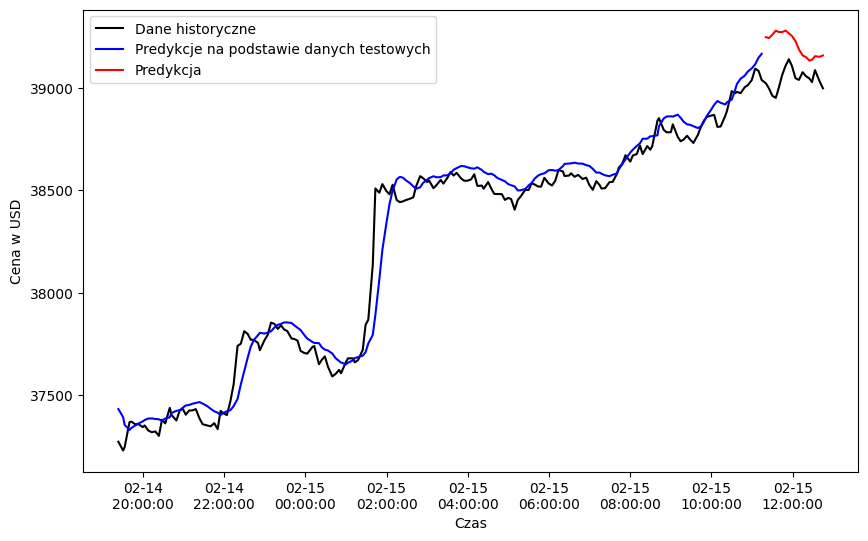

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(data.index[seq_length:len(data)-seq_length], data['Price'][seq_length:len(data)-seq_length], label='Dane historyczne', color='black')
plt.plot(data.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Predykcje na podstawie danych testowych', color='blue')
plt.plot(data.index[range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))], test_predictions, label='Predykcja', color='red')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M:%S'))

plt.xlabel('Czas')
plt.ylabel('Cena w USD')
plt.legend()
plt.show()

### Zakończenie ###

Przewidywane wyniki są dość zbliżone do prawdziwych, choć w wielu miejscach znacznie się odróżniają, co pokazuje wady modelu przy określonej liczbie danych i konfigurowalnych wartościach. Aby uzyskać jak najlepsze wyniki, powyższy program był uruchamiany wielokrotnie z różnymi wartościami konfigurowalnych zmiennych. Wartości które dały najlepszy wynik są obecnie wpisane powyżej. Predykcja (czerwona linia) pokazuje, że rekurencyjne sieci neuronowe LSTM, mogą być wykorzystywane do przewidywania cen kryptowalut, ponieważ linia ta jest dosyć zbliżona do tej która faktycznie się wydarzyła. Warto tu jednak zwrócić uwagę na to, że nie udało się przewidzieć mocnego i krótkiego spadku ceny, co z kolei pokazuje, że rezultat nie jest idealny. Jest on jednak wystarczająco dobry, aby móc na jego podstawie wspierać podejmowane decyzje.

### Źródła:
- https://www.geeksforgeeks.org/time-series-forecasting-using-tensorflow/
- https://en.wikipedia.org/wiki/Long_short-term_memory